# Notebook 4: Motor de Backtesting con Rebalanceo Equiponderado Inteligente

## Objetivo
Motor de backtesting que simula ejecución real con rebalanceo inteligente mensual, costes transaccionales realistas y manejo de delistings.

## Reglas de Ejecución

### Timing de Órdenes
- **VENTA:** Precio OPEN del día de rebalanceo (ej: 31/Ene OPEN)
- **COMPRA:** Precio CLOSE del mismo día (ej: 31/Ene CLOSE)
- **Razón:** Ventas matutinas liberan capital para compras al cierre
    - No se tiene en cuenta en este analisis, pero seria optimo realizar el rebalanceo de esta manera en la vida real por la curva de volumen diario

### Rebalanceo Equiponderado Inteligente
- **Rebalanceo inteligente:** Solo ejecuta trades necesarios para minimizar costos transaccionales
- **Mantiene activos existentes:** Activos que siguen en la nueva selección se mantienen en cartera
- **Vende solo salidas:** Solo vende completamente activos que ya NO están en la nueva selección
- **Compra solo nuevos:** Solo compra activos nuevos que no estaban en la cartera
- **Ajusta posiciones:** Ajusta shares de activos existentes para mantener 5% equiponderado
- **Umbral mínimo de ajuste: $250:** Solo se ajustan posiciones cuando la diferencia entre el valor actual y el objetivo (5% del capital) es mayor a $250. Este umbral optimiza el balance entre mantener equiponderación estricta y evitar sobreajustes que generan comisiones desproporcionadas. Con un umbral de $250, se permite una desviación máxima de ±0.10% del capital total (rango efectivo: 4.90% - 5.10% por activo), manteniendo la cartera muy cercana a la equiponderación ideal mientras reduce significativamente los ajustes menores que consumían beneficios en comisiones innecesarias.
- **Justificación:** Reduce significativamente costos transaccionales manteniendo equiponderación estricta (5% por activo)

### Estructura de Costes
- Comisión = max(0.23% × valor, $23)
    - La comisión es el 0.23% del valor de la transacción, con un mínimo de $23

### Manejo de Delistings
- **Sistema de reservas del Notebook 3**: El Notebook 3 guarda los top 30 activos (20 principales + 10 reservas) para manejar delistings que ocurren entre la fecha de selección (t-1) y la fecha de ejecución (t). Si algún ticker del top 20 no tiene precio CLOSE disponible, se reemplaza automáticamente con el siguiente de la lista de reservas que SÍ tenga precio disponible, garantizando que la cartera siempre tenga exactamente 20 activos válidos.
- **Reemplazo automático**: Antes de ejecutar el rebalanceo, se verifica qué tickers del top 20 no tienen precio disponible. Para cada ticker faltante, se busca en orden (reserva_1, reserva_2, ..., reserva_10) el primer ticker que tenga precio CLOSE válido y se reemplaza. Si no hay suficientes reservas válidas, se muestra advertencia pero se continúa con los disponibles.
- **Venta de activos con delisting en cartera**: Si un activo que ya está en la cartera deja de tener precio OPEN disponible, se vende inmediatamente a último precio disponible, se aplica comisión y se mantiene cash hasta próximo rebalanceo.

## Índice
1. [Configuración e Imports](#configuracion)
2. [Carga de Datos](#carga)
3. [Clase Portfolio](#portfolio)
4. [Loop Principal de Backtesting](#loop)
5. [Guardado de Resultados](#guardado)

---

## 1. Configuración e Imports {#configuracion}

Esta sección configura el entorno de trabajo, importa las librerías necesarias y define los parámetros críticos del motor de backtesting.

**Decisiones clave:**
- **CAPITAL_INICIAL = $250,000**: Capital inicial estándar para backtesting de estrategias institucionales, suficiente para diversificar en 20 activos sin problemas de liquidez o impacto de mercado significativo.
- **TASA_COMISION = 0.23%**: Tasa de comisión realista basada en brokers institucionales para órdenes de tamaño medio. Esta tasa refleja costos reales de ejecución que impactan significativamente el retorno neto de la estrategia.
- **COMISION_MINIMA = $23**: Comisión mínima por trade que refleja estructura de costos real de brokers, especialmente relevante para trades pequeños donde la comisión mínima puede exceder el porcentaje.
- **N_ACTIVOS = 20 y PESO_POR_ACTIVO = 5%**: Equiponderación del 5% por activo, balanceando diversificación (reduce riesgo idiosincrático) con concentración (maximiza exposición a señales de momentum más fuertes). Este tamaño de cartera es estándar en estrategias momentum institucionales.

La configuración asegura que el backtesting simule condiciones realistas de ejecución, crítico para validar la viabilidad de la estrategia antes de implementación en vivo.

In [7]:
"""
Notebook 4: Motor de Backtesting con Rebalanceo Equiponderado Inteligente

Simula ejecución real con:
- Rebalanceo inteligente (solo trades necesarios)
- Costes realistas (0.23%, mínimo $23)
- Manejo de delistings
"""

import numpy as np
import pandas as pd

# Configuración
CAPITAL_INICIAL = 250_000
TASA_COMISION = 0.0023  # 0.23%
COMISION_MINIMA = 23
N_ACTIVOS = 20
PESO_POR_ACTIVO = 0.05  # 5%

DATA_PROCESSED_DIR = '../datos/processed'
DATA_BACKTEST_DIR = '../datos/backtest'

print("="*70)
print("NOTEBOOK 4: MOTOR DE BACKTESTING")
print("="*70)
print(f"Capital inicial: ${CAPITAL_INICIAL:,.0f}")
print(f"Comisión: {TASA_COMISION*100:.2f}% (mínimo ${COMISION_MINIMA:.0f})")
print(f"Activos por cartera: {N_ACTIVOS} (peso {PESO_POR_ACTIVO*100:.0f}% cada uno)")

NOTEBOOK 4: MOTOR DE BACKTESTING
Capital inicial: $250,000
Comisión: 0.23% (mínimo $23)
Activos por cartera: 20 (peso 5% cada uno)


## 2. Carga de Datos {#carga}

Esta sección carga los datos necesarios para ejecutar el backtesting: las selecciones mensuales generadas en el Notebook 3 y los precios OPEN/CLOSE procesados en el Notebook 2.

**Decisiones clave:**
- **Precios OPEN y CLOSE separados**: Se cargan precios OPEN y CLOSE por separado para simular timing realista de ejecución. Las ventas se ejecutan a precio OPEN (matutinas) para liberar capital, y las compras/ajustes se ejecutan a precio CLOSE (cierre) del mismo día, reflejando la práctica operativa real donde las ventas matutinas financian las compras del cierre.
- **Formato mensual**: Los precios están agregados a nivel mensual (Business Month End) porque los rebalanceos ocurren mensualmente. Esto optimiza el procesamiento y elimina la necesidad de trabajar con datos diarios innecesarios.
- **Selecciones del Notebook 3**: Se cargan las selecciones mensuales generadas por la estrategia momentum del Notebook 3, que incluyen 20 activos principales (`ticker_1` a `ticker_20`) y 10 reservas (`reserva_1` a `reserva_10`). Las reservas se usan para reemplazar automáticamente activos que sufran delistings entre la fecha de selección y la fecha de ejecución, asegurando que la cartera siempre tenga exactamente 20 activos válidos.

La carga de datos incluye validaciones de integridad (shapes consistentes, fechas alineadas) para garantizar que el backtesting se ejecute correctamente.

In [8]:
print("\n" + "="*70)
print("CARGANDO DATOS")
print("="*70)

# Cargar selecciones mensuales (incluye 20 principales + 10 reservas)
df_selecciones = pd.read_csv(f'{DATA_PROCESSED_DIR}/selecciones_mensuales.csv', 
                              parse_dates=['fecha'])

# Cargar precios mensuales
prices_open = pd.read_parquet(f'{DATA_PROCESSED_DIR}/prices_monthly_open.parquet')
prices_close = pd.read_parquet(f'{DATA_PROCESSED_DIR}/prices_monthly_close.parquet')

print(f"Selecciones: {df_selecciones.shape}")
print(f"Precios OPEN: {prices_open.shape}")
print(f"Precios CLOSE: {prices_close.shape}")
print(f"Fechas de rebalanceo: {len(df_selecciones)}")

# Verificar que existen columnas de reservas
tiene_reservas = any(col.startswith('reserva_') for col in df_selecciones.columns)
print(f"Columnas de reservas presentes: {tiene_reservas}")

# Verificación
assert len(df_selecciones) > 0, "No hay selecciones cargadas"
assert prices_open.shape == prices_close.shape, "Shapes de precios inconsistentes"
print("\n✓ Datos cargados correctamente")


CARGANDO DATOS
Selecciones: (133, 31)
Precios OPEN: (146, 845)
Precios CLOSE: (146, 845)
Fechas de rebalanceo: 133
Columnas de reservas presentes: True

✓ Datos cargados correctamente


## 3. Clase Portfolio {#portfolio}

Esta sección implementa la clase Portfolio que gestiona el estado del portfolio y ejecuta trades con rebalanceo inteligente.

**Decisiones clave:**
- **Rebalanceo inteligente**: Solo ejecuta trades necesarios (vende salidas, ajusta existentes, compra nuevos) en lugar de liquidar todo cada mes, reduciendo significativamente costos transaccionales. Esta optimización puede reducir trades en 30-50% comparado con full rebalance, impactando directamente el retorno neto.
- **Timing de ejecución**: Ventas a precio OPEN y compras/ajustes a precio CLOSE del mismo día, simulando ejecución real donde ventas matutinas liberan capital para compras al cierre. Este timing es crítico para simular flujos de capital realistas.
- **Ajuste de posiciones**: El método `ajustar_posicion` ajusta shares de activos existentes al 5% del capital total sin necesidad de vender y recomprar completamente, minimizando comisiones. Solo ajusta si la diferencia es significativa (≥$250) para evitar trades innecesarios que generan comisiones desproporcionadas. Este umbral fue optimizado desde $100 a $250 tras análisis que mostró que ajustes menores (ej: $100) representan solo 0.04 puntos porcentuales de desviación (5.00% vs 5.04%), lo cual no justifica pagar $23 de comisión mínima por ajuste. Con $250, se permite una desviación máxima de ±0.10% del capital total (rango: 4.90% - 5.10% por activo), logrando un mejor balance entre equiponderación y costes transaccionales.
- **Manejo de delistings**: Busca último precio disponible cuando un activo no tiene precio OPEN, aplicando comisión y manteniendo cash hasta próximo rebalanceo. Esto previene errores de ejecución y simula manejo realista de activos que dejan de cotizar.

La clase mantiene estado del portfolio (cash, posiciones) y ejecuta todos los trades necesarios para mantener equiponderación (5% por activo), conectando las selecciones del Notebook 3 con la ejecución realista del backtesting.

In [9]:
class Portfolio:
    """
    Gestiona estado del portfolio con rebalanceo inteligente.
    """
    
    def __init__(self, capital_inicial):
        self.cash = capital_inicial
        self.positions = {}  # {ticker: n_shares}
        self.history = []
    
    def liquidar_selectivo(self, tickers_a_vender, precios_open, fecha, prices_close_hist=None):
        """
        Vende solo los tickers especificados a precio OPEN.
        
        Parameters
        ----------
        tickers_a_vender : list
            Lista de tickers a vender (solo los que salen de la selección)
        precios_open : pd.Series
            Precios OPEN del día de rebalanceo
        fecha : pd.Timestamp
            Fecha de rebalanceo
        prices_close_hist : pd.DataFrame, optional
            Histórico de precios CLOSE para buscar último precio en delistings
        
        Returns
        -------
        list
            Lista de trades de venta ejecutados
        """
        trades = []
        
        for ticker in tickers_a_vender:
            if ticker not in self.positions:
                continue
            
            shares = self.positions[ticker]
            
            # Verificar si ticker tiene precio OPEN disponible
            if ticker not in precios_open.index or pd.isna(precios_open[ticker]):
                # Ticker sin precio (delisting), buscar último precio disponible
                precio = self._buscar_ultimo_precio(ticker, fecha, prices_close_hist)
                if pd.isna(precio):
                    print(f"ADVERTENCIA: {ticker} sin precio disponible en {fecha}, liquidando a $0")
                    precio = 0.0
            else:
                precio = precios_open[ticker]
            
            valor_venta = shares * precio
            comision = max(valor_venta * TASA_COMISION, COMISION_MINIMA)
            
            self.cash += (valor_venta - comision)
            
            # Eliminar de posiciones
            del self.positions[ticker]
            
            trades.append({
                'fecha': fecha,
                'ticker': ticker,
                'tipo': 'VENTA',
                'shares': shares,
                'precio': precio,
                'valor': valor_venta,
                'comision': comision
            })
        
        return trades
    
    def ajustar_posicion(self, ticker, capital_total, precio_close, fecha):
        """
        Ajusta posición existente al 5% del capital total.
        
        Parameters
        ----------
        ticker : str
            Ticker a ajustar
        capital_total : float
            Capital total del portfolio (cash + valor posiciones)
        precio_close : float
            Precio CLOSE del día
        fecha : pd.Timestamp
            Fecha de rebalanceo
        
        Returns
        -------
        dict or None
            Trade ejecutado o None si no hay ajuste necesario
        """
        if ticker not in self.positions:
            return None
        
        shares_actuales = self.positions[ticker]
        valor_actual = shares_actuales * precio_close
        
        # Calcular valor objetivo (5% del capital total)
        valor_objetivo = capital_total * PESO_POR_ACTIVO
        diferencia = valor_objetivo - valor_actual
        
        # Si la diferencia es muy pequeña (< $250), no ajustar para evitar comisiones innecesarias
        # Umbral optimizado: $250 permite desviación máxima de ±0.10% del capital (rango: 4.90%-5.10%)
        # evitando sobreajustes menores que generan comisiones desproporcionadas
        if abs(diferencia) < 250:
            return None
        
        if diferencia > 0:
            # Comprar más shares
            comision_est = max(diferencia * TASA_COMISION, COMISION_MINIMA)
            capital_neto = diferencia - comision_est
            shares_adicionales = int(capital_neto / precio_close)
            
            if shares_adicionales == 0:
                return None
            
            valor_compra = shares_adicionales * precio_close
            comision_real = max(valor_compra * TASA_COMISION, COMISION_MINIMA)
            costo_total = valor_compra + comision_real
            
            if costo_total > self.cash:
                return None
            
            self.cash -= costo_total
            self.positions[ticker] = shares_actuales + shares_adicionales
            
            return {
                'fecha': fecha,
                'ticker': ticker,
                'tipo': 'AJUSTE_COMPRA',
                'shares': shares_adicionales,
                'precio': precio_close,
                'valor': valor_compra,
                'comision': comision_real
            }
        else:
            # Vender shares (diferencia negativa)
            shares_a_vender = int(abs(diferencia) / precio_close)
            
            if shares_a_vender == 0 or shares_a_vender >= shares_actuales:
                return None
            
            valor_venta = shares_a_vender * precio_close
            comision = max(valor_venta * TASA_COMISION, COMISION_MINIMA)
            
            self.cash += (valor_venta - comision)
            self.positions[ticker] = shares_actuales - shares_a_vender
            
            return {
                'fecha': fecha,
                'ticker': ticker,
                'tipo': 'AJUSTE_VENTA',
                'shares': shares_a_vender,
                'precio': precio_close,
                'valor': valor_venta,
                'comision': comision
            }
    
    def rebalancear_equiponderado(self, tickers_nuevos, precios_close, fecha):
        """
        Rebalancea cartera de forma inteligente: mantiene existentes, ajusta posiciones, compra nuevos.
        
        Parameters
        ----------
        tickers_nuevos : list
            Lista de 20 tickers objetivo de la nueva selección
        precios_close : pd.Series
            Precios CLOSE del día de rebalanceo
        fecha : pd.Timestamp
            Fecha de rebalanceo
        
        Returns
        -------
        list
            Lista de trades ejecutados (ajustes + compras)
        """
        trades = []
        
        # Calcular capital total actual (cash + valor posiciones)
        valor_posiciones = 0.0
        for ticker, shares in self.positions.items():
            if ticker in precios_close.index and pd.notna(precios_close[ticker]):
                valor_posiciones += shares * precios_close[ticker]
        
        capital_total = self.cash + valor_posiciones
        
        # Identificar tickers a mantener, ajustar y comprar
        tickers_actuales = set(self.positions.keys())
        tickers_nuevos_set = set(tickers_nuevos)
        tickers_a_mantener = tickers_actuales.intersection(tickers_nuevos_set)
        
        # 1. Ajustar posiciones de tickers que se mantienen
        for ticker in tickers_a_mantener:
            if ticker not in precios_close.index or pd.isna(precios_close[ticker]):
                continue
            
            precio = precios_close[ticker]
            if precio <= 0:
                continue
            
            trade_ajuste = self.ajustar_posicion(ticker, capital_total, precio, fecha)
            if trade_ajuste is not None:
                trades.append(trade_ajuste)
                # Recalcular capital total después del ajuste
                valor_posiciones = sum(
                    self.positions.get(t, 0) * precios_close.get(t, 0)
                    for t in self.positions
                    if t in precios_close.index and pd.notna(precios_close[t])
                )
                capital_total = self.cash + valor_posiciones
        
        # 2. Comprar tickers nuevos
        tickers_a_comprar = tickers_nuevos_set - tickers_actuales
        capital_por_activo = capital_total * PESO_POR_ACTIVO
        
        for ticker in tickers_a_comprar:
            if ticker not in precios_close.index or pd.isna(precios_close[ticker]):
                print(f"ADVERTENCIA: {ticker} sin precio CLOSE en {fecha}, omitiendo")
                continue
            
            precio = precios_close[ticker]
            
            if precio <= 0:
                print(f"ADVERTENCIA: {ticker} tiene precio <= 0 en {fecha}, omitiendo")
                continue
            
            # Calcular shares considerando comisión
            comision_est = max(capital_por_activo * TASA_COMISION, COMISION_MINIMA)
            capital_neto = capital_por_activo - comision_est
            shares = int(capital_neto / precio)
            
            if shares == 0:
                continue
            
            # Recalcular valores exactos
            valor_compra = shares * precio
            comision_real = max(valor_compra * TASA_COMISION, COMISION_MINIMA)
            costo_total = valor_compra + comision_real
            
            # Verificar que hay suficiente cash
            if costo_total > self.cash:
                # Ajustar shares si no hay suficiente cash
                capital_disponible = self.cash
                if capital_disponible < COMISION_MINIMA:
                    continue
                capital_neto_ajustado = capital_disponible - COMISION_MINIMA
                shares = int(capital_neto_ajustado / precio)
                if shares == 0:
                    continue
                valor_compra = shares * precio
                comision_real = max(valor_compra * TASA_COMISION, COMISION_MINIMA)
                costo_total = valor_compra + comision_real
            
            # Ejecutar compra
            self.cash -= costo_total
            self.positions[ticker] = shares
            
            trades.append({
                'fecha': fecha,
                'ticker': ticker,
                'tipo': 'COMPRA',
                'shares': shares,
                'precio': precio,
                'valor': valor_compra,
                'comision': comision_real
            })
        
        return trades
    
    def valor_total(self, precios_close):
        """
        Calcula valor total del portfolio.
        
        Parameters
        ----------
        precios_close : pd.Series
            Precios CLOSE del día
        
        Returns
        -------
        float
            Valor total del portfolio (cash + posiciones)
        """
        valor_posiciones = 0.0
        for ticker, shares in self.positions.items():
            if ticker in precios_close.index and pd.notna(precios_close[ticker]):
                valor_posiciones += shares * precios_close[ticker]
        
        return self.cash + valor_posiciones
    
    def _buscar_ultimo_precio(self, ticker, fecha_actual, prices_close_hist=None):
        """
        Busca último precio disponible antes de fecha_actual.
        
        Parameters
        ----------
        ticker : str
            Ticker del activo
        fecha_actual : pd.Timestamp
            Fecha actual
        prices_close_hist : pd.DataFrame, optional
            Histórico de precios CLOSE
        
        Returns
        -------
        float
            Último precio disponible o NaN
        """
        if prices_close_hist is None:
            return np.nan
        
        if ticker not in prices_close_hist.columns:
            return np.nan
        
        # Buscar último precio antes de fecha_actual
        precios_ticker = prices_close_hist[ticker].loc[:fecha_actual]
        precios_validos = precios_ticker.dropna()
        
        if len(precios_validos) > 0:
            return precios_validos.iloc[-1]
        
        return np.nan

print("✓ Clase Portfolio definida")

✓ Clase Portfolio definida


## 4. Loop Principal de Backtesting {#loop}

Esta sección ejecuta el backtesting iterando sobre todas las fechas de rebalanceo, aplicando el rebalanceo inteligente mes a mes.

**Decisiones clave:**
- **Reemplazo automático con reservas**: Antes de procesar la selección, se verifica qué tickers del top 20 no tienen precio CLOSE disponible. Cada ticker faltante se reemplaza automáticamente con el siguiente de la lista de reservas (reserva_1 a reserva_10) que SÍ tenga precio disponible, garantizando que siempre se trabaje con exactamente 20 tickers válidos. Este sistema maneja delistings que ocurren entre la fecha de selección (t-1) y la fecha de ejecución (t).
- **Identificar tickers a vender primero**: Se calcula la diferencia entre cartera actual y nueva selección (después del reemplazo con reservas) antes de ejecutar trades, optimizando el proceso y permitiendo validaciones tempranas. Esta separación lógica (reemplazar → identificar → vender → rebalancear) facilita debugging y análisis posterior.
- **Validación de cartera después de cada rebalanceo**: Se verifica que la cartera tenga exactamente los 20 tickers de la selección después de cada rebalanceo, detectando errores de ejecución (tickers sin precio, problemas de cash) inmediatamente. Esta validación es crítica para garantizar integridad del backtesting.
- **Snapshots mensuales**: Se guarda estado completo del portfolio (equity, cash, número de posiciones) después de cada rebalanceo para análisis posterior y construcción de equity curve. Estos snapshots permiten análisis de drawdowns, volatilidad y evolución del cash, esenciales para el Notebook 5.

El loop registra todos los trades ejecutados (ventas, compras, ajustes) con detalles completos (fecha, ticker, tipo, shares, precio, valor, comisión) para análisis de costos transaccionales y validación del rebalanceo inteligente.

In [10]:
def reemplazar_tickers_sin_precio(tickers_principales, reservas, precios_close_dia, fecha):
    """
    Reemplaza tickers del top 20 que no tienen precio disponible con reservas válidas.
    
    Este sistema maneja delistings que ocurren entre la fecha de selección (t-1) 
    y la fecha de ejecución (t). Para cada ticker sin precio, busca en orden 
    (reserva_1, reserva_2, ..., reserva_10) el primer ticker que tenga precio 
    CLOSE válido y lo reemplaza.
    
    Parameters
    ----------
    tickers_principales : list
        Lista de 20 tickers principales del top 20
    reservas : list
        Lista de 10 tickers de reserva (puede contener None)
    precios_close_dia : pd.Series
        Precios CLOSE del día de rebalanceo
    fecha : pd.Timestamp
        Fecha de rebalanceo
    
    Returns
    -------
    list
        Lista de 20 tickers válidos (con reemplazos aplicados)
    list
        Lista de reemplazos realizados [(ticker_original, ticker_reemplazo), ...]
    """
    tickers_validos = []
    reemplazos = []
    reservas_usadas = set()  # Evitar usar la misma reserva dos veces
    
    for ticker in tickers_principales:
        # Verificar si ticker tiene precio disponible
        tiene_precio = (ticker in precios_close_dia.index and 
                       pd.notna(precios_close_dia[ticker]) and 
                       precios_close_dia[ticker] > 0)
        
        if tiene_precio:
            # Ticker válido, mantenerlo
            tickers_validos.append(ticker)
        else:
            # Ticker sin precio, buscar reemplazo en reservas
            reemplazo_encontrado = False
            for reserva in reservas:
                if reserva is None or reserva in reservas_usadas:
                    continue
                
                # Verificar si reserva tiene precio disponible
                reserva_valida = (reserva in precios_close_dia.index and 
                                 pd.notna(precios_close_dia[reserva]) and 
                                 precios_close_dia[reserva] > 0)
                
                if reserva_valida:
                    tickers_validos.append(reserva)
                    reemplazos.append((ticker, reserva))
                    reservas_usadas.add(reserva)
                    reemplazo_encontrado = True
                    break
            
            if not reemplazo_encontrado:
                # No se encontró reemplazo válido, mantener ticker original (se omitirá después)
                tickers_validos.append(ticker)
                print(f"ADVERTENCIA: {fecha.date()} - {ticker} sin precio y sin reserva válida disponible")
    
    return tickers_validos, reemplazos


print("\n" + "="*70)
print("EJECUTANDO BACKTESTING CON REBALANCEO INTELIGENTE")
print("="*70)

# Inicializar
portfolio = Portfolio(CAPITAL_INICIAL)
historial_trades = []
historial_equity = []
total_reemplazos = 0

# Iterar por fechas de rebalanceo
for i, row in df_selecciones.iterrows():
    fecha = row['fecha']
    
    # Extraer tickers principales (top 20)
    tickers_principales = [row[f'ticker_{j+1}'] for j in range(N_ACTIVOS) 
                          if pd.notna(row[f'ticker_{j+1}'])]
    
    # Extraer reservas (posiciones 21-30)
    reservas = [row.get(f'reserva_{j+1}') for j in range(10) 
                if pd.notna(row.get(f'reserva_{j+1}'))]
    
    # Obtener precios del día
    precios_open_dia = prices_open.loc[fecha]
    precios_close_dia = prices_close.loc[fecha]
    
    # Reemplazar tickers sin precio con reservas válidas
    # Esto maneja delistings que ocurren entre fecha de selección (t-1) y ejecución (t)
    tickers_nuevos, reemplazos = reemplazar_tickers_sin_precio(
        tickers_principales, reservas, precios_close_dia, fecha
    )
    
    if reemplazos:
        total_reemplazos += len(reemplazos)
        for ticker_orig, ticker_reemplazo in reemplazos:
            print(f"  {fecha.date()}: Reemplazado {ticker_orig} → {ticker_reemplazo} (sin precio CLOSE)")
    
    # Filtrar tickers que finalmente no tienen precio (después de intentar reemplazo)
    tickers_nuevos = [t for t in tickers_nuevos 
                     if t in precios_close_dia.index and 
                     pd.notna(precios_close_dia[t]) and 
                     precios_close_dia[t] > 0]
    
    # 1. Identificar tickers a vender (están en cartera pero NO en nueva selección)
    tickers_actuales = set(portfolio.positions.keys())
    tickers_nuevos_set = set(tickers_nuevos)
    tickers_a_vender = list(tickers_actuales - tickers_nuevos_set)
    
    # 2. Vender solo tickers que ya no están en la selección (a OPEN)
    trades_venta = []
    if tickers_a_vender:
        trades_venta = portfolio.liquidar_selectivo(tickers_a_vender, precios_open_dia, fecha, prices_close)
        historial_trades.extend(trades_venta)
    
    # 3. Rebalancear cartera (ajustar existentes + comprar nuevos) a CLOSE
    trades_rebalanceo = portfolio.rebalancear_equiponderado(tickers_nuevos, precios_close_dia, fecha)
    historial_trades.extend(trades_rebalanceo)
    
    # 4. Calcular valor del portfolio al cierre
    equity = portfolio.valor_total(precios_close_dia)
    
    # 5. Validación: verificar que cartera tiene los 20 tickers correctos
    tickers_en_cartera = set(portfolio.positions.keys())
    if tickers_en_cartera != tickers_nuevos_set:
        faltantes = tickers_nuevos_set - tickers_en_cartera
        sobrantes = tickers_en_cartera - tickers_nuevos_set
        if faltantes or sobrantes:
            print(f"ADVERTENCIA: {fecha.date()} - Faltantes: {faltantes}, Sobrantes: {sobrantes}")
    
    # 6. Guardar snapshot
    historial_equity.append({
        'fecha': fecha,
        'equity': equity,
        'cash': portfolio.cash,
        'n_positions': len(portfolio.positions)
    })
    
    # Progress
    if (i + 1) % 20 == 0:
        ret_pct = (equity / CAPITAL_INICIAL - 1) * 100
        n_trades_mes = len(trades_venta) + len(trades_rebalanceo)
        print(f"  {fecha.date()}: Equity=${equity:,.0f} | Retorno={ret_pct:+.2f}% | Trades={n_trades_mes}")

print(f"\n✓ Backtesting completado: {len(historial_equity)} rebalanceos")
print(f"  Total reemplazos por delistings: {total_reemplazos}")

# Convertir a DataFrames
df_equity = pd.DataFrame(historial_equity)
df_trades = pd.DataFrame(historial_trades)

# Calcular retorno total
retorno_total = (df_equity['equity'].iloc[-1] / CAPITAL_INICIAL - 1) * 100
total_comisiones = df_trades['comision'].sum()

print(f"\nResumen preliminar:")
print(f"  Capital inicial:   ${CAPITAL_INICIAL:,.0f}")
print(f"  Capital final:     ${df_equity['equity'].iloc[-1]:,.0f}")
print(f"  Retorno total:     {retorno_total:+.2f}%")
print(f"  Total trades:      {len(df_trades):,}")
print(f"  Total comisiones:  ${total_comisiones:,.2f}")


EJECUTANDO BACKTESTING CON REBALANCEO INTELIGENTE
  2015-04-30: Reemplazado AGN-201503 → HBI-202511 (sin precio CLOSE)
  2015-08-31: Reemplazado KRFT-201507 → SWKS (sin precio CLOSE)
  2015-09-30: Reemplazado PLL-201508 → RCL (sin precio CLOSE)
  2015-10-30: Reemplazado HSP-201509 → NVDA (sin precio CLOSE)
  2016-04-29: Reemplazado GMCR-201603 → EXR (sin precio CLOSE)
  2016-05-31: Reemplazado ADT-201604 → TWC-201605 (sin precio CLOSE)
  2016-08-31: Equity=$278,698 | Retorno=+11.48% | Trades=28
  2018-04-30: Equity=$379,384 | Retorno=+51.75% | Trades=26
  2018-10-31: Reemplazado ANDV-201809 → FFIV (sin precio CLOSE)
  2019-01-31: Reemplazado SCG-201812 → AZO (sin precio CLOSE)
  2019-09-30: Reemplazado APC-201908 → TFX (sin precio CLOSE)
  2019-10-31: Reemplazado TSS-201909 → NOC (sin precio CLOSE)
  2019-12-31: Equity=$367,674 | Retorno=+47.07% | Trades=24
  2021-08-31: Equity=$470,640 | Retorno=+88.26% | Trades=29
  2023-04-28: Equity=$408,373 | Retorno=+63.35% | Trades=28
  2024-12

## 4.1. Visualizaciones del Backtesting

Visualizaciones que analizan el desempeño del backtesting, la eficiencia del rebalanceo inteligente y la evolución de trades y comisiones.

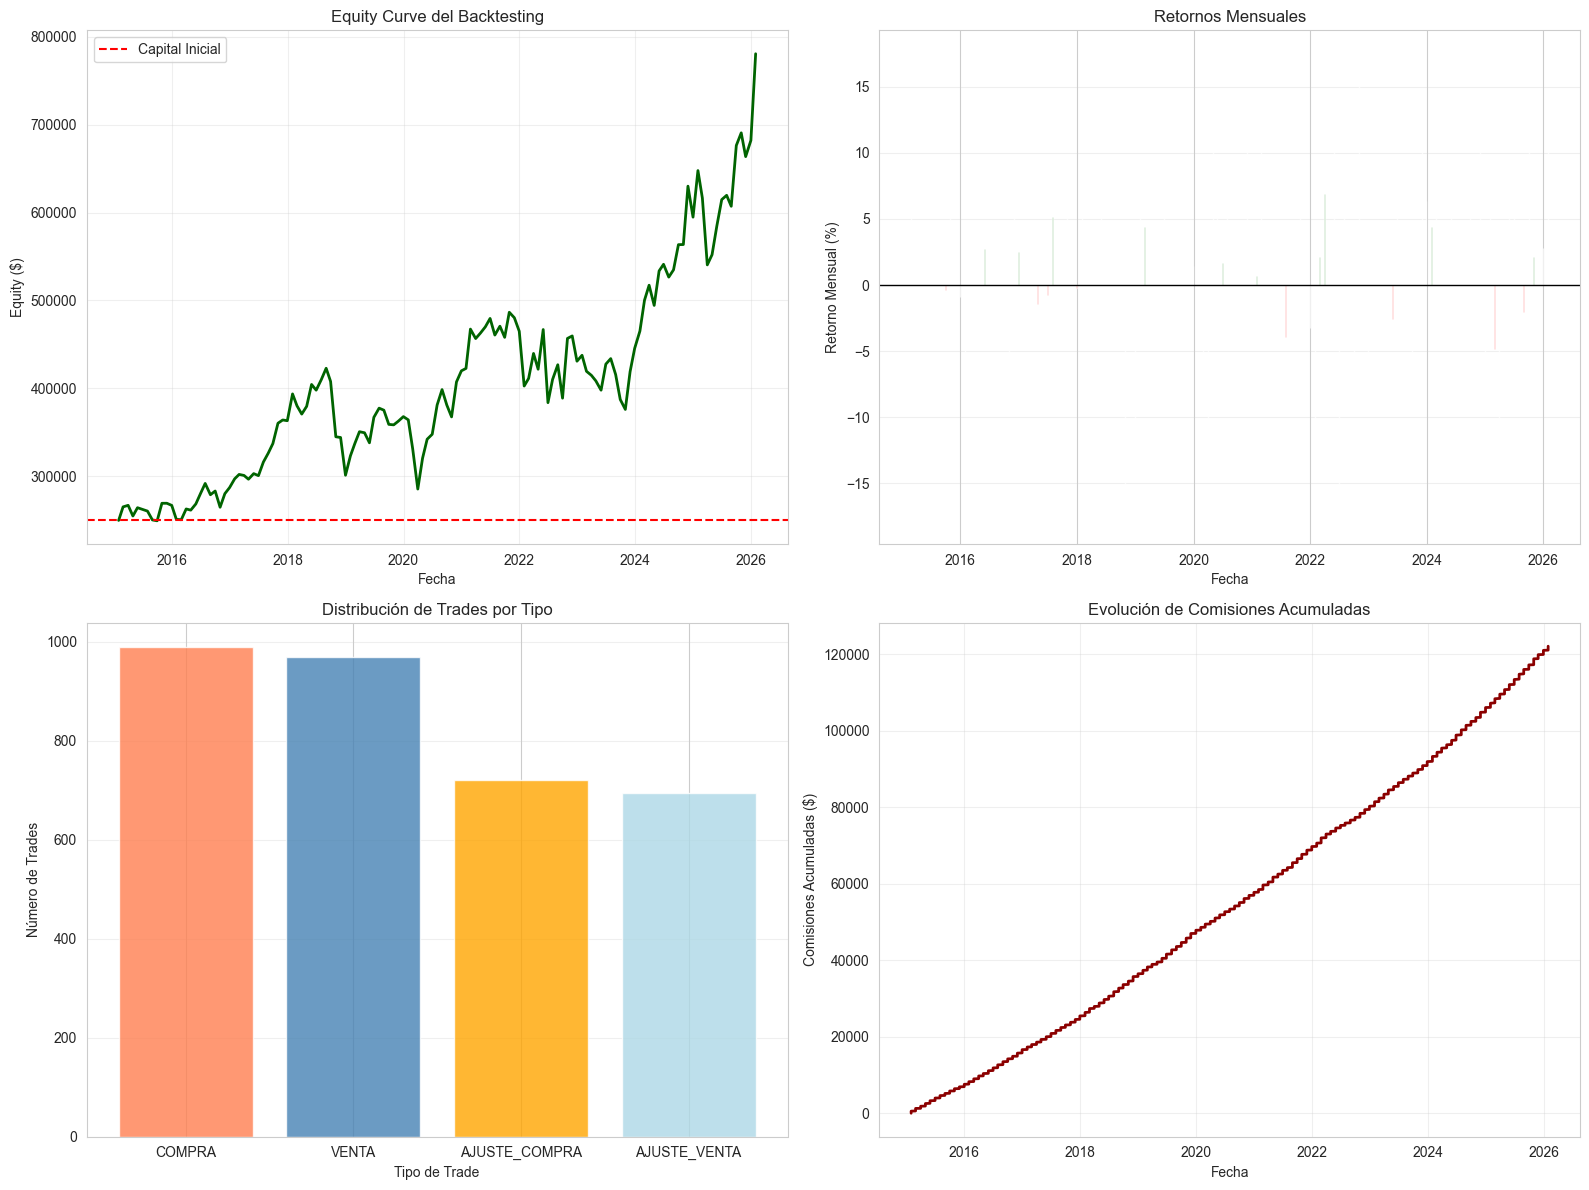


Eficiencia del Rebalanceo Inteligente:
  Trades con full rebalance: 5,320
  Trades con rebalanceo inteligente: 3,374
  Reducción: 36.6%


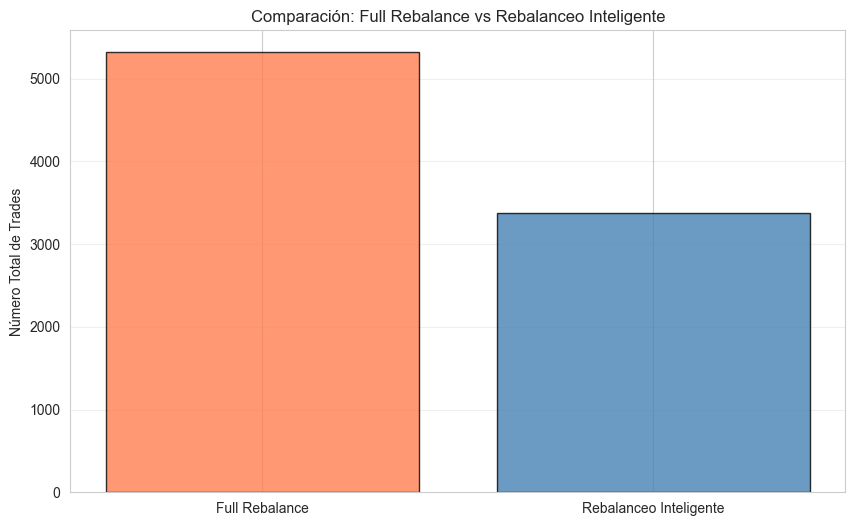

In [14]:

import seaborn as sns

# Configurar estilo
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (14, 6)

# 1. Equity Curve y Retornos Mensuales
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Gráfico 1: Equity Curve
axes[0, 0].plot(df_equity['fecha'], df_equity['equity'], linewidth=2, color='darkgreen')
axes[0, 0].axhline(CAPITAL_INICIAL, color='red', linestyle='--', label='Capital Inicial')
axes[0, 0].set_xlabel('Fecha')
axes[0, 0].set_ylabel('Equity ($)')
axes[0, 0].set_title('Equity Curve del Backtesting')
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Gráfico 2: Retornos Mensuales
df_equity['retorno_mensual'] = df_equity['equity'].pct_change() * 100
axes[0, 1].bar(df_equity['fecha'], df_equity['retorno_mensual'], 
               color=['green' if x > 0 else 'red' for x in df_equity['retorno_mensual']],
               alpha=0.7)
axes[0, 1].axhline(0, color='black', linewidth=1)
axes[0, 1].set_xlabel('Fecha')
axes[0, 1].set_ylabel('Retorno Mensual (%)')
axes[0, 1].set_title('Retornos Mensuales')
axes[0, 1].grid(alpha=0.3, axis='y')

# Gráfico 3: Distribución de Trades por Tipo
trades_por_tipo = df_trades['tipo'].value_counts()
axes[1, 0].bar(trades_por_tipo.index, trades_por_tipo.values,
               color=['coral', 'steelblue', 'orange', 'lightblue'], alpha=0.8)
axes[1, 0].set_xlabel('Tipo de Trade')
axes[1, 0].set_ylabel('Número de Trades')
axes[1, 0].set_title('Distribución de Trades por Tipo')
axes[1, 0].grid(alpha=0.3, axis='y')

# Gráfico 4: Evolución de Comisiones Acumuladas
df_trades_sorted = df_trades.sort_values('fecha')
df_trades_sorted['comisiones_acum'] = df_trades_sorted['comision'].cumsum()
axes[1, 1].plot(df_trades_sorted['fecha'], df_trades_sorted['comisiones_acum'],
                linewidth=2, color='darkred')
axes[1, 1].set_xlabel('Fecha')
axes[1, 1].set_ylabel('Comisiones Acumuladas ($)')
axes[1, 1].set_title('Evolución de Comisiones Acumuladas')
axes[1, 1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

# 3. Comparación: Rebalanceo Inteligente vs Full Rebalance
trades_full_rebalance = len(df_equity) * 40  # 20 ventas + 20 compras por mes
trades_inteligente = len(df_trades)
reduccion = (1 - trades_inteligente / trades_full_rebalance) * 100

print(f"\nEficiencia del Rebalanceo Inteligente:")
print(f"  Trades con full rebalance: {trades_full_rebalance:,}")
print(f"  Trades con rebalanceo inteligente: {trades_inteligente:,}")
print(f"  Reducción: {reduccion:.1f}%")

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(['Full Rebalance', 'Rebalanceo Inteligente'],
       [trades_full_rebalance, trades_inteligente],
       color=['coral', 'steelblue'], alpha=0.8, edgecolor='black')
ax.set_ylabel('Número Total de Trades')
ax.set_title('Comparación: Full Rebalance vs Rebalanceo Inteligente')
ax.grid(alpha=0.3, axis='y')
plt.show()

## 5. Guardado de Resultados {#guardado}

Esta sección guarda los resultados del backtesting en formatos optimizados para análisis posterior en el Notebook 5.

**Decisiones clave:**
- **Formato parquet para equity curve**: Se guarda la equity curve en formato parquet por eficiencia de almacenamiento y velocidad de lectura. El archivo contiene fechas, equity, cash y número de posiciones, permitiendo análisis rápido de drawdowns, volatilidad y evolución del portfolio sin necesidad de recalcular.
- **Formato CSV para trades**: Se guardan todos los trades en CSV por legibilidad y facilidad de análisis manual. El formato CSV permite inspección directa de trades individuales, análisis de costos por ticker y validación de la lógica de rebalanceo inteligente.
- **Estadísticas de eficiencia**: Se calculan y muestran estadísticas comparativas (trades promedio por mes, reducción vs full rebalance) para validar que el rebalanceo inteligente está funcionando correctamente y reduciendo costos transaccionales significativamente.

Los archivos guardados (`equity_curve.parquet` y `trades.csv`) son la entrada principal para el Notebook 5, donde se realizarán análisis comparativos con el benchmark y cálculo de métricas de riesgo/retorno.

In [16]:
print("\n" + "="*70)
print("GUARDANDO RESULTADOS")
print("="*70)

# Guardar equity curve
equity_path = f'{DATA_BACKTEST_DIR}/equity_curve.parquet'
df_equity.to_parquet(equity_path, index=False)
print(f"✓ Equity curve guardada: {equity_path}")

# Guardar trades
trades_path = f'{DATA_BACKTEST_DIR}/trades.csv'
df_trades.to_csv(trades_path, index=False)
print(f"✓ Trades guardados: {trades_path}")

# Resumen final
print("\n" + "="*70)
print("RESUMEN DE BACKTESTING")
print("="*70)
print(f"Capital inicial:   ${CAPITAL_INICIAL:,.0f}")
print(f"Capital final:     ${df_equity['equity'].iloc[-1]:,.0f}")
print(f"Retorno total:     {retorno_total:+.2f}%")
print(f"Total trades:      {len(df_trades):,}")
print(f"  - Ventas:        {len(df_trades[df_trades['tipo'] == 'VENTA']):,}")
print(f"  - Compras:       {len(df_trades[df_trades['tipo'] == 'COMPRA']):,}")
print(f"  - Ajustes compra: {len(df_trades[df_trades['tipo'] == 'AJUSTE_COMPRA']):,}")
print(f"  - Ajustes venta:  {len(df_trades[df_trades['tipo'] == 'AJUSTE_VENTA']):,}")
print(f"Total comisiones:  ${total_comisiones:,.2f}")
print(f"% en comisiones:   {total_comisiones/CAPITAL_INICIAL*100:.2f}%")

# Estadísticas de eficiencia
trades_por_mes = len(df_trades) / len(df_equity)
print(f"\nEficiencia del rebalanceo inteligente:")
print(f"  Trades promedio por mes: {trades_por_mes:.1f}")
print(f"  (vs. ~40 trades/mes con full rebalance: 20 ventas + 20 compras)")

print("\n" + "="*70)
print("NOTEBOOK 4 COMPLETADO")
print("="*70)
print("\nPróximo paso: Notebook 5 - Comparativa y Métricas")


GUARDANDO RESULTADOS
✓ Equity curve guardada: ../datos/backtest/equity_curve.parquet
✓ Trades guardados: ../datos/backtest/trades.csv

RESUMEN DE BACKTESTING
Capital inicial:   $250,000
Capital final:     $780,904
Retorno total:     +212.36%
Total trades:      3,374
  - Ventas:        969
  - Compras:       989
  - Ajustes compra: 721
  - Ajustes venta:  695
Total comisiones:  $122,133.01
% en comisiones:   48.85%

Eficiencia del rebalanceo inteligente:
  Trades promedio por mes: 25.4
  (vs. ~40 trades/mes con full rebalance: 20 ventas + 20 compras)

NOTEBOOK 4 COMPLETADO

Próximo paso: Notebook 5 - Comparativa y Métricas
